## Is This Tweet Referring to a Disaster or Not?

Dataset Source: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.24.2
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1
         Torch: 1.13.1
      Evaluate: 0.4.0


#### Load & Start Preprocessing Dataset

In [3]:
parent_dir = "/Users/briandunn/Desktop/nlp_ds/Disaster Tweets"

data_file = os.path.join(parent_dir, "tweets.csv")

data = pd.read_csv(data_file)

data.drop(columns=['id', 'keyword', 'location'], inplace=True)

data.rename(columns={"target": "labels"}, inplace=True)

data

,text,labels
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...
11365,Media should have warned us well in advance. T...,0
11366,i feel directly attacked 💀 i consider moonbin ...,0
11367,i feel directly attacked 💀 i consider moonbin ...,0
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


#### Define Dictionaries to Convert Between String & Integer Class Values

In [4]:
unique_labels = ["non-disaster", "disaster"]
id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}
NUM_OF_LABELS = len(unique_labels)

#### Visual: Histogram of Text Lengths

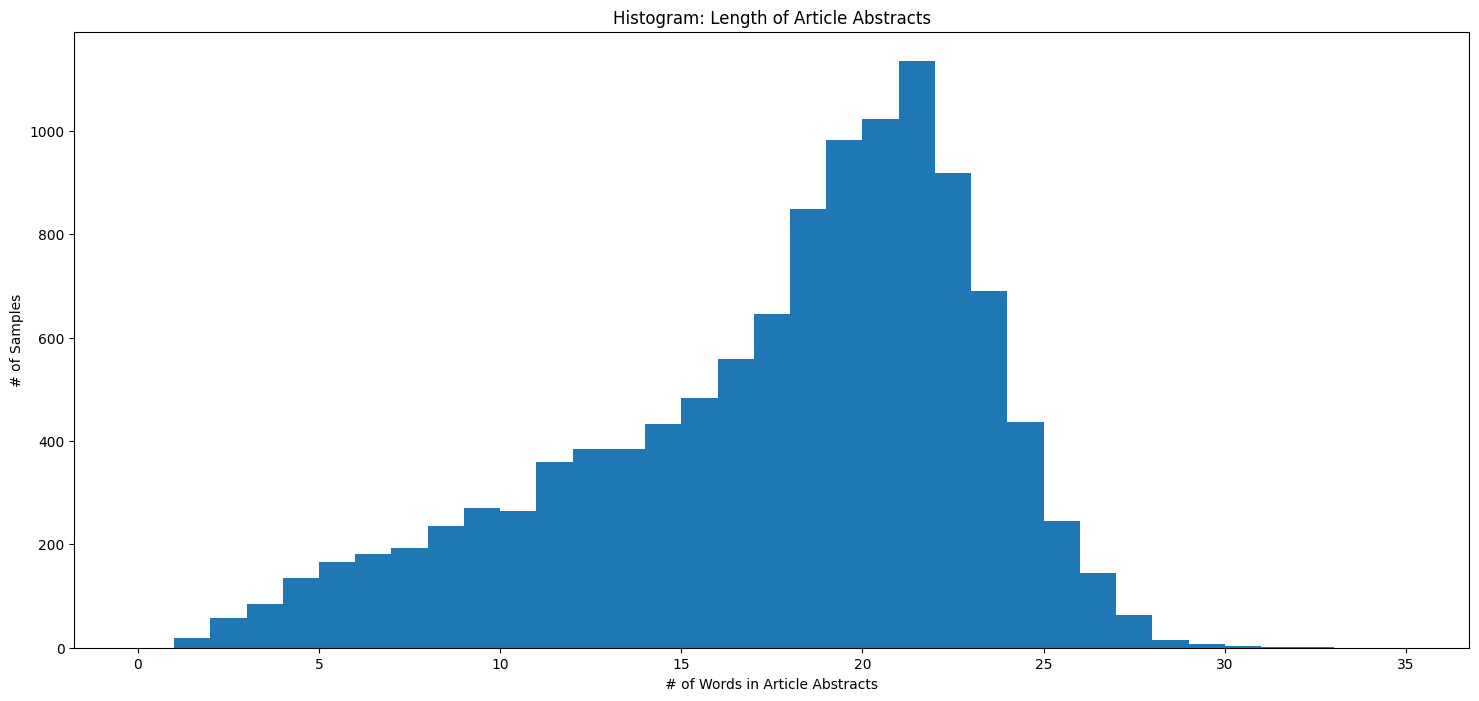

The maximum length of Article Abstracts (in words) is 32 words.


In [5]:
data['text_length'] = data['text'].str.split().str.len()

n_bin=35
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Article Abstracts')
plt.xlabel('# of Words in Article Abstracts')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Article Abstracts (in words) is {max(data['text_length'])} words.")

#### Visual: Tweet Length by Class

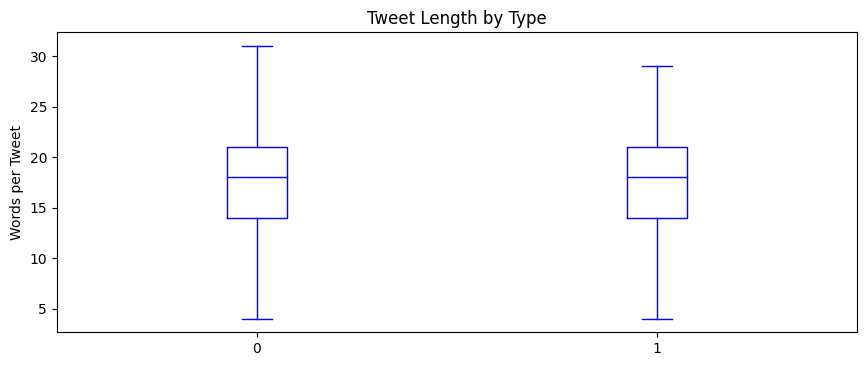

In [6]:
data.boxplot("text_length", by="labels", grid=False, showfliers=False, color="Blue", figsize=(10,4))

plt.suptitle('')
plt.title('Tweet Length by Type')
plt.xlabel('')
plt.ylabel('Words per Tweet')
plt.show()

#### Find Largest Tokenized Input Value

In [7]:
MODEL_CKPT = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                             truncation=True, 
                                             padding=True,
                                             batched=True, 
                                             batch_size=None)

text_len = [len(tokenizer.encode(a)) for a in data["text"]]

print(f"The longest article length is {max(text_len)} tokens.")

The longest article length is 264 tokens.


#### Final Data Preprocessing

In [8]:
data.drop(columns=["text_length"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11370 non-null  object
 1   labels  11370 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 177.8+ KB


#### Convert DataFrame to Dataset & Split Dataset into Training & Evaluation Datasets

In [9]:
dataset = Dataset.from_pandas(data)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (9096, 2)
Testing Dataset Shape: (1137, 2)
Evaluation Dataset Shape: (1137, 2)


#### Basic Values/Constants

In [10]:
set_seed = 42
NUM_OF_EPOCHS = 5

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = int(max(text_len) * 1.02)
MODEL_CKPT = "roberta-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Tweet_About_Disaster_Or_Not"

METRIC_NAME = "f1"
DEVICE = torch.device("cpu")

print(f"This project will utilize the {DEVICE} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will utilize the cpu to train and evaluate.
This project will have a maximum length for the input text of 269 tokens.
The model checkpoint used for this project is: roberta-base


#### Tokenize Entire Dataset

In [11]:
# Define the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], 
                     padding=True, 
                     truncation=True, 
                     max_length=MAX_LENGTH, 
                     return_tensors="pt")

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

training data shape: (9096, 4)
testing data shape: (1137, 4)
validation data shape: (1137, 4)
{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 9096
})


#### Instantiate Model

In [12]:
model = (
    AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=NUM_OF_LABELS,
        ignore_mismatched_sizes=True
    ).to(DEVICE))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

#### Define Function to Compute Metrics

In [13]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["precision"]
    
    return {"accuracy" : accuracy, 
            "F1" : f1_score,
            "Recall" : recall,
            "Precision" : precision,
            }

#### Define TrainingArguments

In [14]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    weight_decay=0.01,
    log_level="error",
    logging_strategy='epoch', 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    load_best_model_at_end=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Data Collator

In [15]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Handle Class Imbalance

In [16]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [17]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['eval'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/roberta-base-Tweet_About_Disaster_Or_Not into local empty directory.


#### Train Model

In [18]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


A Jupyter Widget

{'loss': 0.6918, 'learning_rate': 1.9972027972027975e-05, 'epoch': 0.01}
{'loss': 0.372, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


A Jupyter Widget

{'eval_loss': 0.30668747425079346, 'eval_accuracy': 0.8689533861037819, 'eval_F1': 0.7204502814258913, 'eval_Recall': 0.8807339449541285, 'eval_Precision': 0.6095238095238096, 'eval_runtime': 156.0129, 'eval_samples_per_second': 7.288, 'eval_steps_per_second': 0.115, 'epoch': 1.0}
{'loss': 0.2356, 'learning_rate': 1.2e-05, 'epoch': 2.0}


A Jupyter Widget

{'eval_loss': 0.26400184631347656, 'eval_accuracy': 0.8988566402814424, 'eval_F1': 0.7568710359408034, 'eval_Recall': 0.8211009174311926, 'eval_Precision': 0.7019607843137254, 'eval_runtime': 87.9374, 'eval_samples_per_second': 12.93, 'eval_steps_per_second': 0.205, 'epoch': 2.0}
{'loss': 0.165, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


A Jupyter Widget

{'eval_loss': 0.3028873801231384, 'eval_accuracy': 0.899736147757256, 'eval_F1': 0.7634854771784233, 'eval_Recall': 0.8440366972477065, 'eval_Precision': 0.696969696969697, 'eval_runtime': 92.2048, 'eval_samples_per_second': 12.331, 'eval_steps_per_second': 0.195, 'epoch': 3.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.1118, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


A Jupyter Widget

{'eval_loss': 0.32564088702201843, 'eval_accuracy': 0.8970976253298153, 'eval_F1': 0.7577639751552794, 'eval_Recall': 0.8394495412844036, 'eval_Precision': 0.690566037735849, 'eval_runtime': 93.3786, 'eval_samples_per_second': 12.176, 'eval_steps_per_second': 0.193, 'epoch': 4.0}
{'loss': 0.0766, 'learning_rate': 0.0, 'epoch': 5.0}


A Jupyter Widget

{'eval_loss': 0.37328827381134033, 'eval_accuracy': 0.9023746701846965, 'eval_F1': 0.7711340206185566, 'eval_Recall': 0.8577981651376146, 'eval_Precision': 0.700374531835206, 'eval_runtime': 91.5149, 'eval_samples_per_second': 12.424, 'eval_steps_per_second': 0.197, 'epoch': 5.0}
{'train_runtime': 59665.5483, 'train_samples_per_second': 0.762, 'train_steps_per_second': 0.012, 'train_loss': 0.19265806224796322, 'epoch': 5.0}


#### Save & Log Mertics on Training Dataset

In [19]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/roberta-base-Tweet_About_Disaster_Or_Not
   3fc57cb..802027c  main -> main



A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/roberta-base-Tweet_About_Disaster_Or_Not
   802027c..4f7919f  main -> main



***** train metrics *****
  epoch                    =         5.0
  train_loss               =      0.1927
  train_runtime            = 16:34:25.54
  train_samples_per_second =       0.762
  train_steps_per_second   =       0.012


#### Evaluate Model

In [20]:
metrics = trainer.evaluate(encoded_data['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

A Jupyter Widget

***** eval metrics *****
  epoch                   =        5.0
  eval_F1                 =     0.7569
  eval_Precision          =      0.702
  eval_Recall             =     0.8211
  eval_accuracy           =     0.8989
  eval_loss               =      0.264
  eval_runtime            = 0:01:32.27
  eval_samples_per_second =     12.322
  eval_steps_per_second   =      0.195


#### Push Model to HuggingFace Hub

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/roberta-base-Tweet_About_Disaster_Or_Not
   4f7919f..5303e20  main -> main



A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/roberta-base-Tweet_About_Disaster_Or_Not
   5303e20..efb1bb0  main -> main



'https://huggingface.co/DunnBC22/roberta-base-Tweet_About_Disaster_Or_Not/commit/5303e200e87b8bf838112c34973bf9661bbd7682'

### Notes & Other Takeaways From This Project
****
- This project is part of a series of binary classification models that I am using the same dataset with virtually everything identical with the exception of the transformer used (& potentially the maximum length of tokens to accommodate the various transformer requirements). The idea is to see which one is most effective and efficient.
****